# AutoEncoder with DSA data
1. lyingRigh + lyingBack을 noraml로/ jumping을 abnormal로 설정
2. normal + abnormal로 테스트 데이터 사용
3. normal 데이터로 AE 훈련
4. 테스트 데이터를 AE에 넣어서 Reconstruction err 구함
5. 적당한 threshold값 찾기

______
## 1. 데이터 불러오기

In [44]:
import pandas as pd

df = pd.read_csv(r"C:\Users\DoHyeonjik\GachonUniv\3-2\datasets\DL\DSA_features.csv")
df.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1


In [45]:
#데이터 보기
#구조
print(df.shape)
#activity 클래스 별 개수
print(df['activity'].value_counts())

(9120, 272)
activity
sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot                 480
movingInElevator           480
standingInElevatorStill    480
decendingStairs            480
ascendingStairs            480
lyingRigh                  480
lyingBack                  480
basketBall                 480
Name: count, dtype: int64


## 2. 데이터 전처리

In [46]:
# lyingRigh +  lyingBack을 normal로, jumping을 abnormal로 설정
lyingRigh = df[df.activity=='lyingRigh']
lyingBack = df[df.activity=='lyingBack']
jumping = df[df.activity=='jumping']

normal_data = pd.concat([lyingRigh, lyingBack], axis=0)
abnormal_data = jumping

print(normal_data.shape)
print(abnormal_data.shape)



(960, 272)
(480, 272)


In [47]:
# normal + abnormal을 test로 사용하기 위해서 생성
train_data = normal_data
test_data = pd.concat([normal_data, abnormal_data], axis=0)
print(test_data.shape)

(1440, 272)


In [48]:
# 훈련세트의 레이블은 버리고, 테스트세트의 레이블은 남김
train_data = train_data.drop(['people','activity'], axis=1)

y_test = test_data['activity']
test_data = test_data.drop(['people','activity'], axis=1)

print(train_data.shape, test_data.shape)

(960, 270) (1440, 270)


In [49]:
# 정규화 진행
from sklearn.preprocessing import StandardScaler
ss=  StandardScaler()
ss.fit(train_data)
train_data = ss.transform(train_data)
test_data = ss.transform(test_data)

## 3. 모델 생성

In [50]:
from tensorflow import keras
from keras.layers import Dense, Input
from keras.models import Model

input_dim = train_data.shape[1] # 270

input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(input_dim, activation='relu')(decoded)

AE = Model(inputs = input_layer, outputs= decoded)
AE.compile(optimizer='adam', loss='mse')

AE.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 270)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          34,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 270)                 │          17,550 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,742 (256.80 KB)

 Trainable params: 65,742 (256.80 KB)

 Non-trainable params: 0 (0.00 B)

## 4. 훈련

In [51]:
history = AE.fit(train_data, train_data, epochs=50, batch_size=256, shuffle=True, validation_split=0.1)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 1.0510 - val_loss: 0.5008
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1255 - val_loss: 0.5013
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9150 - val_loss: 0.5010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9977 - val_loss: 0.4991
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0398 - val_loss: 0.4967
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8903 - val_loss: 0.4942
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7833 - val_loss: 0.4901
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9320 - val_loss: 0.4843
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8964 - val_loss: 0.4792
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7547 - val_loss: 0.4763
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8351 - val_loss: 0.4745
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7539 - val_loss: 0.4719
E

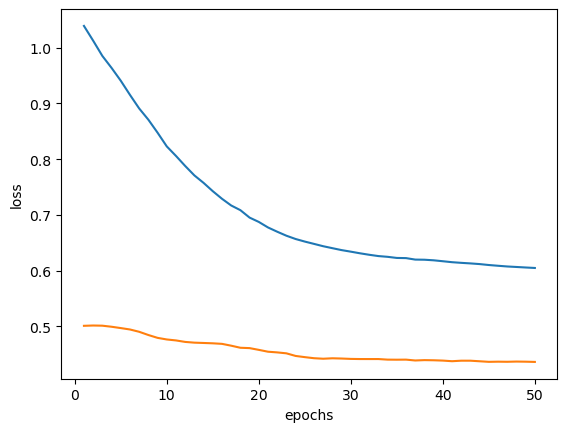

In [52]:
# 시각화
import matplotlib.pyplot as plt

epochs = range(1,51)
plt.plot(epochs, history.history['loss'], label = "loss")
plt.plot(epochs, history.history['val_loss'], label = "val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


## 5. predictions + threshold 찾기

In [53]:
import numpy as np

predictions = AE.predict(test_data)
mse = np.mean(np.power(test_data - predictions, 2),axis=1)
error_df = pd.DataFrame({"Reconstruction_Error": mse, "True_Class": y_test})

error_df.describe()

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Reconstruction_Error
count,1.440000e+03
mean,8.921725e+05
std,1.955645e+06
min,1.410188e-01
25%,2.862394e-01
50%,4.102726e-01
75%,5.568411e+05
max,2.397998e+07


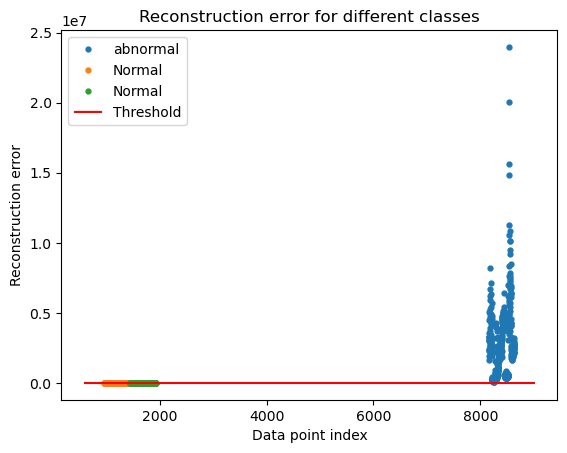

In [63]:
threshold= 1

groups = error_df.groupby('True_Class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_Error, marker='o', ms=3.5, linestyle='',
            label= "abnormal" if name == "jumping" else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();